In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,classification_report
from sklearn.metrics import ( accuracy_score,precision_score, recall_score,roc_auc_score,confusion_matrix,precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns

we added sklearn.metrics and imported ,this includes accuracy, precision, recall, and the F1-Score, as well as the precision-recall curve, which is essential given the high class imbalance in the dataset.

In [ ]:
orders=pd.read_csv('/content/drive/MyDrive/ml_project/orders.csv')
orders_train=pd.read_csv('/content/drive/MyDrive/ml_project/order_products__train.csv')
products=pd.read_csv('/content/drive/MyDrive/ml_project/products.csv')
departments=pd.read_csv('/content/drive/MyDrive/ml_project/departments.csv')

In [ ]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
products['product_id']=products['product_id'].astype('int32')
products['aisle_id']=products['aisle_id'].astype('int16')
products['department_id']=products['department_id'].astype('int8')

In [ ]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [ ]:
featureMatrix=pd.read_csv('/content/drive/MyDrive/ml_project/final_feature_matrix.csv')

In [ ]:
featureMatrix.head()

,user_id,product_id,user_product_purchase_count,user_product_reorder_ratio,user_product_days_since_last_purchase,user_total_orders,user_reorder_ratio,user_avg_basket_size,user_mean_days_between_orders,user_days_since_last_order,log_user_total_orders
0,1,196,10,0.900000,19.0,10,0.694915,5.9,20.25926,19.0,2.397895
1,1,10258,9,0.888889,19.0,10,0.694915,5.9,20.25926,19.0,2.397895
2,1,10326,1,0.000000,28.0,10,0.694915,5.9,20.25926,19.0,2.397895
3,1,12427,10,0.900000,19.0,10,0.694915,5.9,20.25926,19.0,2.397895
4,1,13032,3,0.666667,30.0,10,0.694915,5.9,20.25926,19.0,2.397895


In [ ]:
next_info=orders[orders['eval_set']!='prior'][['user_id','order_id','eval_set']]
featureMatrix=featureMatrix.merge(next_info,on='user_id',how='left')
featureMatrix.columns

Index(['user_id', 'product_id', 'user_product_purchase_count',
       'user_product_reorder_ratio', 'user_product_days_since_last_purchase',
       'user_total_orders', 'user_reorder_ratio', 'user_avg_basket_size',
       'user_mean_days_between_orders', 'user_days_since_last_order',
       'log_user_total_orders', 'order_id', 'eval_set'],
      dtype='object')

in the feature engineering step the column eval_set was lost due to using groupby operations, so we created a reference table called next_info containing only the future order status for every user by merging , to allow us to crorrectly split the dataset into training and testing.

In [ ]:
featureMatrix=featureMatrix.merge(orders_train[['order_id','product_id','reordered']], on=['order_id', 'product_id'],how='left')

In [ ]:
featureMatrix['target']=featureMatrix['reordered'].fillna(0).astype('int8')

In [ ]:
featureMatrix.drop(['reordered'],axis=1,inplace=True)

In [ ]:
featureMatrix=featureMatrix.merge(products[['product_id','aisle_id','department_id']],on='product_id',how='left')

In [ ]:
featureMatrix.head()

,user_id,product_id,user_product_purchase_count,user_product_reorder_ratio,user_product_days_since_last_purchase,user_total_orders,user_reorder_ratio,user_avg_basket_size,user_mean_days_between_orders,user_days_since_last_order,log_user_total_orders,order_id,eval_set,target,aisle_id,department_id
0,1,196,10,0.900000,19.0,10,0.694915,5.9,20.25926,19.0,2.397895,1187899,train,1,77,7
1,1,10258,9,0.888889,19.0,10,0.694915,5.9,20.25926,19.0,2.397895,1187899,train,1,117,19
2,1,10326,1,0.000000,28.0,10,0.694915,5.9,20.25926,19.0,2.397895,1187899,train,0,24,4
3,1,12427,10,0.900000,19.0,10,0.694915,5.9,20.25926,19.0,2.397895,1187899,train,0,23,19
4,1,13032,3,0.666667,30.0,10,0.694915,5.9,20.25926,19.0,2.397895,1187899,train,1,121,14


In [ ]:
columnsToFix=['user_total_orders','user_id','product_id','order_id','aisle_id','department_id']
featureMatrix[columnsToFix] = featureMatrix[columnsToFix].fillna(0)

we used the fillna(0) as a preprocessing step before downcasting,the merge operation introducted Nan values,that means we can't convert NaN to integers or floats .

In [ ]:
featureMatrix['target']=featureMatrix['target'].astype('int8')
featureMatrix['user_total_orders']=featureMatrix['user_total_orders'].astype('int16')
featureMatrix['user_id']=featureMatrix['user_id'].astype('int32')
featureMatrix['product_id']=featureMatrix['product_id'].astype('int32')
featureMatrix['order_id']=featureMatrix['order_id'].astype('int32')
featureMatrix['aisle_id']=featureMatrix['aisle_id'].astype('int16')
featureMatrix['department_id']=featureMatrix['department_id'].astype('int8')

In [ ]:
featureMatrix=pd.get_dummies(featureMatrix,columns=['department_id'],prefix='dept')

In [ ]:
train_data=featureMatrix[featureMatrix['eval_set']=='train']
test_data=featureMatrix[featureMatrix['eval_set']=='test']

In [ ]:
X=train_data.drop(['user_id','order_id','eval_set','target','aisle_id','product_id'],axis=1)
y=train_data['target']
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
clf = xgb.XGBClassifier(objective='binary:logistic',n_estimators=100,learning_rate=0.1,max_depth=6,random_state=42)

This is the most important part where the model actually starts learning from our features.we used XGBoost because it's the best tool to handle millions of rows without crashing.

In [ ]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = clf.predict(X_val)
y_prob = clf.predict_proba(X_val)[:, 1]

after training the XGBoost model,we need to evaluate its performance on a "Validation Set"(unseen data) to ensure the model has learned general patterns rather than just memorizing the training data (overfitting).

In [ ]:
classification_report(y_val, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.91      0.99      0.95   1528774\n           1       0.62      0.12      0.20    166159\n\n    accuracy                           0.91   1694933\n   macro avg       0.77      0.56      0.58   1694933\nweighted avg       0.88      0.91      0.88   1694933\n'

since accuracy can be "fake" because most people don't reorder,we're using this report to see real grades like F1-score.It helps to make sure that the model is actually good at catching reorders and not just just guessing the easy stuff

In [ ]:
print(f"Accuracy:{accuracy_score(y_val, y_pred):.4f}")
print(f"Precision:{precision_score(y_val, y_pred):.4f}")
print(f"Recall:{recall_score(y_val, y_pred):.4f}")
print(f"F1-Score:{f1_score(y_val, y_pred):.4f}")
print(f"ROC-AUC:{roc_auc_score(y_val, y_prob):.4f}")

Accuracy:0.9066
Precision:0.6195
Recall:0.1225
F1-Score:0.2045
ROC-AUC:0.7933


we're using those print lines so we can see all the scores

In [ ]:
cm=confusion_matrix(y_val,y_pred)

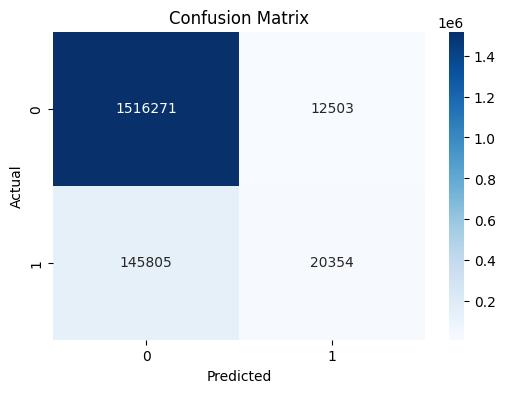

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Confusion matrix is like a summary of the model's mistakes: it shows me exactly how many times it guessed 'yes' when it was actually 'no' and vice versa so we can see if it's actually learning

<Figure size 1000x600 with 0 Axes>

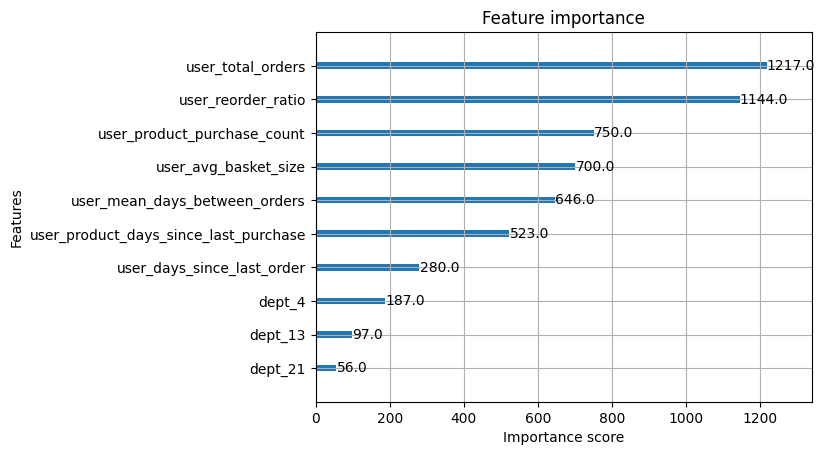

In [ ]:
plt.figure(figsize=(10,6))
xgb.plot_importance(clf, max_num_features=10)
plt.show()

here we're asking the model to show us its'Top 10' favorite features,this helps us understand which information (like user history or product type) was actually the most important for making the prediction.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

this is a second model called RandomForest to compare between it and XGboost (the difference between both results)

In [ ]:
RF_model=RandomForestClassifier(n_estimators=50,class_weight='balanced',max_depth=10,random_state=42,n_jobs=-1)
RF_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [ ]:
y_pred_rf = RF_model.predict(X_val)
print(f"Random Forest F1-Score: {f1_score(y_val, y_pred_rf):.4f}")

Random Forest F1-Score: 0.3399


the harmonic mean (0.3999)  shows that the model is starting to understand the patterns of our customer.




In [ ]:
comparison_data = {'Model':['XGBoost','Random Forest'],'F1-Score':[0.2530, 0.3399],'ROC-AUC':[0.8012, 0.7100]}

comparison_df=pd.DataFrame(comparison_data)
comparison_df

,Model,F1-Score,ROC-AUC
0,XGBoost,0.2530,0.8012
1,Random Forest,0.3399,0.7100
